# Existing Smallplexes in Los Angeles

For our group project, my team is researching the potential impact that the recently passed SB 9 can have on the supply of housing in Los Angeles California. One of our data sources will higlight lots in the city with existing smallplexes. This can potentially show the lack of availability of smallplexes as a housing option for Los Angeles residents, and how SB 9 can make smallplexes in Los Angeles a more common and affordable housing option. The dataset I used is the Building Permit Database available [here](https://data.lacity.org/City-Infrastructure-Service-Requests/Building-and-Safety-Permit-Information-Old/yv23-pmwf/data).  

We also wanted to highlight the neighborhoods that currently have smallplexes as housing options and the neighborhoods that do not. This can potentially show that smallplexes are effective housing options for households with low to middle income. The dataset I used for neighborhoods is the LA Times Neighborhood Data available [here](https://geohub.lacity.org/datasets/la-times-neighborhood-boundaries/explore)

For the purposes of this notebook, smallplexes will be defined as any strcture that has 2 to 4 housing units on the same lot. This notebook goes on to highlight the availability of smallplexes prior to the implementation of SB 9. 

## Step 1

I imported all the libraries I potentially need.

In [1]:
import pandas as pd

import geopandas as gpd

import contextily as ctx

import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

import matplotlib.pyplot as plt

import plotly.express as px

## Step 2

I imported both datasets I will be using in this notebook

In [2]:
Smallplex_Data = gpd.read_file('data/Smallplex Data.csv')

In [3]:
Neighborhood_Boundaries = gpd.read_file('data/LA_Times_Neighborhood_Boundaries.zip')

## Step 3

I explored the smallplex data like I did in the previous weeks.

In [4]:
Smallplex_Data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 56 columns):
 #   Column                                    Non-Null Count  Dtype   
---  ------                                    --------------  -----   
 0   Assessor Book                             2352 non-null   object  
 1   Assessor Page                             2352 non-null   object  
 2   Assessor Parcel                           2352 non-null   object  
 3   Tract                                     2352 non-null   object  
 4   Block                                     2352 non-null   object  
 5   Lot                                       2352 non-null   object  
 6   Reference # (Old Permit #)                2352 non-null   object  
 7   PCIS Permit #                             2352 non-null   object  
 8   Status                                    2352 non-null   object  
 9   Status Date                               2352 non-null   object  
 10  Permit Type     

In [5]:
Smallplex_Data.sample(5)

Assessor Book Assessor Page Assessor Parcel  \
1806          5107             1              18   
1641          5202            14              10   
765           5202            20               6   
206           5179            15               1   
1706          6006             3               8   

                                      Tract Block  Lot  \
1806                      OLD CLAPP ORCHARD     1   23   
1641                         BOSTON HEIGHTS    17   10   
765                          BOSTON HEIGHTS    15    5   
206                        EAST END TERRACE          2   
1706  METLER'S MAIN STREET-SOUTH PARK TRACT        107   

     Reference # (Old Permit #)      PCIS Permit #       Status Status Date  \
1806                  17LA95302  17010-10000-03633  CofO Issued       43315   
1641                  14LA40960  14010-10000-02402  CofO Issued       42974   
765                   19SL68437  19010-70000-03918       Issued       43802   
206                   18LA04989  18016-10000-09907  CofO Issued       43687   
1706                  18LA09899  18010-10000-01533  CofO Issued       43656   

      ...     Applicant Address 1 Applicant Address 2   Applicant Address 3  \
1806  ...      19841 LEXINGTON LN                      HUNTINGTON BEACH, CA   
1641  ...    19841 LEXINGTON LANE                      HUNTINGTON BEACH, CA   
765   ...  2905 S VERMONT AVE#205                           LOS ANGELES, CA   
206   ...       622 S ANDERSON ST                #106                LA, CA   
1706  ...        5452 OCEANUS DR.                      HUNTINGTON BEACH, CA   

           Zone Occupancy Floor Area-L.A. Building Code Definition  \
1806      RD2-1                                               3497   
1641      RD2-1                                               3400   
765       RD2-1                                               5040   
206   C2-1-CUGU                                                  0   
1706       R3-1                                               4041   

     Census Tract  Latitude   Longitude geometry  
1806       2287.1  33.98932  -118.32603     None  
1641         2031  34.01288  -118.29613     None  
765          2031  33.93179  -118.26153     None  
206          2039  34.06161  -118.43201     None  
1706      2392.02   33.9713  -118.25911     None  

[5 rows x 56 columns]

## Step 4 

I added a geometry column because the CSV file did not  come with one.

In [6]:
Smallplex_Data_With_Geometry = gpd.GeoDataFrame(Smallplex_Data,
                                                crs='epsg:4326',
                                                geometry= gpd.points_from_xy(Smallplex_Data.Longitude, Smallplex_Data.Latitude))

In [7]:
Smallplex_Data_With_Geometry.sample(5)

Assessor Book Assessor Page Assessor Parcel  \
2231          6032            33              11   
1027          5040            18               9   
920           5003             5              20   
1826          5305            42               3   
217           2328            10              57   

                                                  Tract Block Lot  \
2231                                            TR 1976        29   
1027                                        AHERN BLOCK         9   
920                                             TR 1571        35   
1826  EDWARD D. SILENT AND CO'S SUBDIVISION OF A PAR...        52   
217                                            TR 12964         1   

     Reference # (Old Permit #)      PCIS Permit #       Status Status Date  \
2231                  16LA60457  15010-10000-03294  CofO Issued       42620   
1027                  17LA94775  17010-70000-00795  CofO Issued       43667   
920                   15SL56601  14010-70000-03767  CofO Issued       42424   
1826                  18SL63289  16010-70000-05390  CofO Issued       43410   
217                   15LA50430  14010-10000-03111  CofO Issued       42867   

      ... Applicant Address 1 Applicant Address 2   Applicant Address 3  \
2231  ...  19841 LEXINGTON LN                      HUNTINGTON BEACH, CA   
1027  ...   8804 BEVERLY BLVD                           PICO RIVERA, CA   
920   ...   3006 S VERMONT AV                 190        LOS ANGELES CA   
1826  ...  7801 TELEGRAPH RD.                            MONTEBELLO, CA   
217   ...     1053 LINDEN AVE                              GLENDALE, CA   

         Zone      Occupancy Floor Area-L.A. Building Code Definition  \
2231     R2-1  R3 Occ. Group                                     3628   
1027  RD1.5-1                                                    4273   
920   [Q]R4-1                                                    3420   
1826  RD1.5-1   U Occ. Group                                     3302   
217   [Q]R3-1                                                    6507   

     Census Tract  Latitude   Longitude                     geometry  
2231       2383.2  33.95367  -118.28674  POINT (-118.28674 33.95367)  
1027         2226  34.04976  -118.33014  POINT (-118.33014 34.04976)  
920          2324  34.10402    -118.316  POINT (-118.31600 34.10402)  
1826      2013.01  33.97182  -118.28584  POINT (-118.28584 33.97182)  
217        1235.1  33.97857  -118.41114  POINT (-118.41114 33.97857)  

[5 rows x 56 columns]

## Step 5 

I cleaned up the dataset by dropping the unimportant columns

In [8]:
columns_to_keep = ['PCIS Permit #',
                   'Permit Type',
                   'Initiating Office',
                   'Issue Date',
                   'Zip Code',
                   'Valuation',
                   '# of Residential Dwelling Units',
                   'Census Tract',
                   'Latitude',
                   'Longitude',
                   'Zone',
                   'geometry']

In [9]:
Smallplex_Data_With_Geometry = Smallplex_Data_With_Geometry[columns_to_keep]

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
Smallplex_Data_With_Geometry.sample(5)

PCIS Permit #        Permit Type Initiating Office Issue Date  \
401   17014-20000-00515           Bldg-New          VAN NUYS      42871   
325   18010-10000-04631           Bldg-New             METRO      43445   
2018  16016-70000-16715  Bldg-Alter/Repair          SOUTH LA      42704   
594   17010-70000-00863           Bldg-New          SOUTH LA      43021   
2119  12016-20000-16636  Bldg-Alter/Repair          VAN NUYS      42152   

     Zip Code Valuation # of Residential Dwelling Units Census Tract  \
401     91602    180000                               2         1432   
325     90038    278000                               2       1917.2   
2018    90003     60000                               2      2392.02   
594     90029    168385                               2         1915   
2119    91405     60000                               2       1272.1   

      Latitude   Longitude         Zone                     geometry  
401   34.07731  -118.36358  RD1.5-1-RIO  POINT (-118.36358 34.07731)  
325    33.9799  -118.28742    RD1.5-1XL  POINT (-118.28742 33.97990)  
2018  33.93202  -118.26161       C2-1VL  POINT (-118.26161 33.93202)  
594   33.98349  -118.33363       R3-1XL  POINT (-118.33363 33.98349)  
2119  33.94127  -118.28734      (Q)R3-1  POINT (-118.28734 33.94127)

## Step 6 

I changed Latitude and Longitude to 'float' to better manipulate the data.

In [12]:
Smallplex_Data_With_Geometry['Latitude'] = Smallplex_Data_With_Geometry.Latitude.astype(float)
Smallplex_Data_With_Geometry['Longitude'] = Smallplex_Data_With_Geometry.Longitude.astype(float)

## Step 7 

I mapped out the existing smallplexes in Los Angeles and separated them into duplexes, triplexes, and quadplexes.

In [13]:
Smallplex_Data_With_Geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
Smallplex_Data_With_Geometry = Smallplex_Data_With_Geometry.to_crs(epsg=3857)

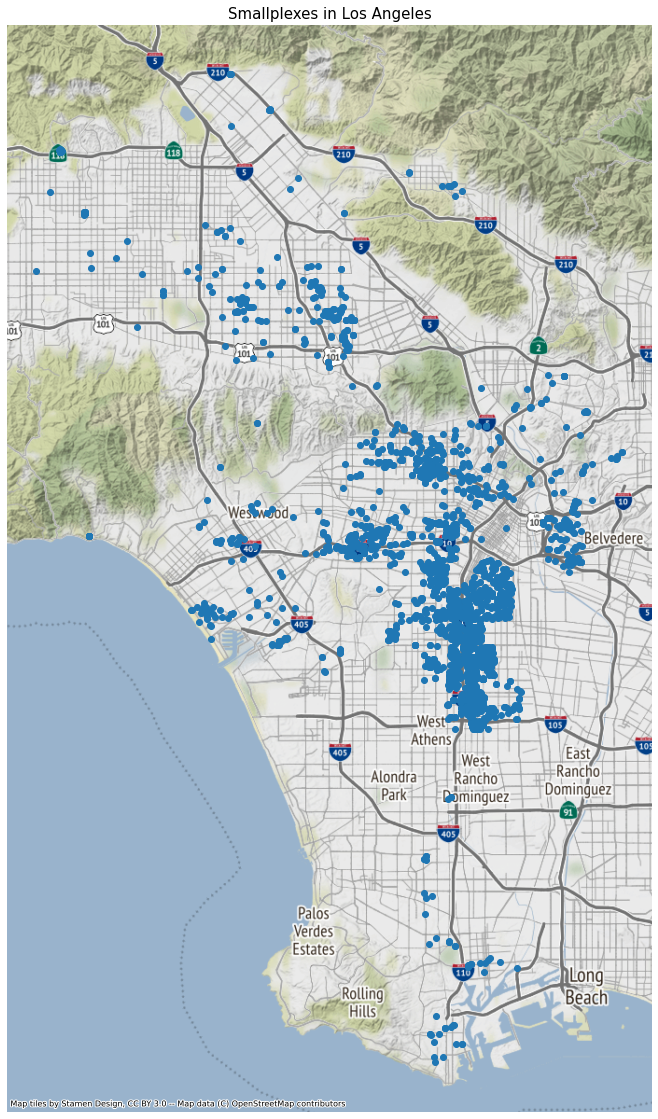

In [15]:
ax = Smallplex_Data_With_Geometry.plot(figsize=(20,20))
ax.set_title('Smallplexes in Los Angeles', fontsize = 15)
ax.axis('off')
ctx.add_basemap(ax)

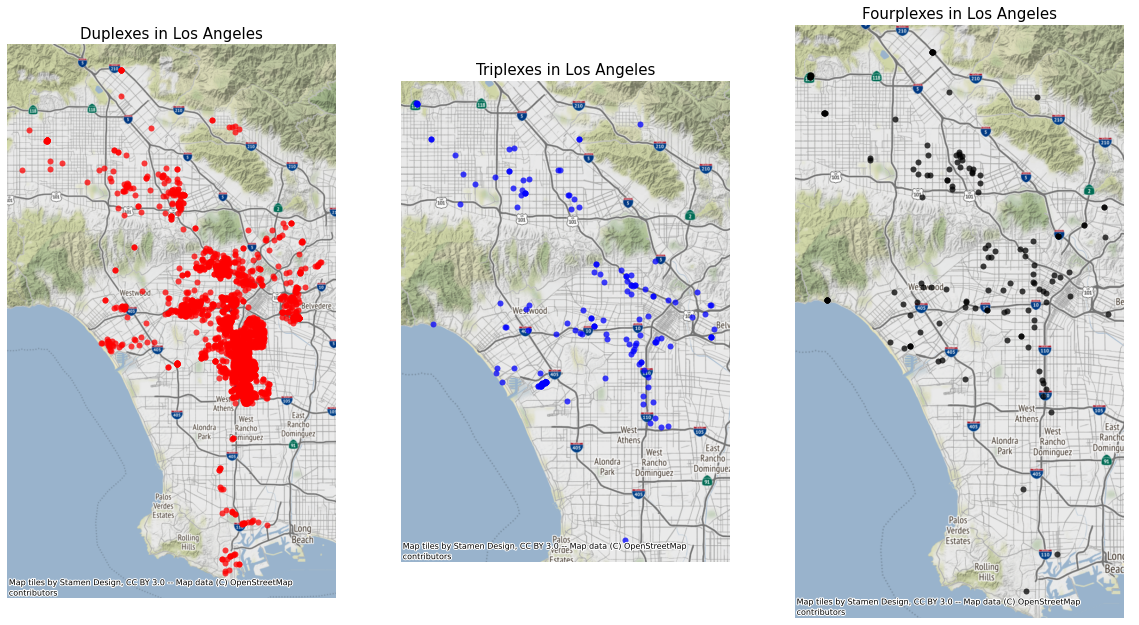

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
ax1, ax2, ax3 = axs

Smallplex_Data_With_Geometry[Smallplex_Data_With_Geometry['# of Residential Dwelling Units'] == '2'].plot(figsize=(20,20), color = 'r', linewidth = 0, alpha = 0.75, ax = ax1)
ax1.axis("off")
ax1.set_title('Duplexes in Los Angeles', fontsize=15)
ctx.add_basemap(ax1)

Smallplex_Data_With_Geometry[Smallplex_Data_With_Geometry['# of Residential Dwelling Units'] == '3'].plot(figsize=(20,20), color = 'b', linewidth = 0, alpha = 0.75, ax = ax2)
ax2.axis("off")
ax2.set_title('Triplexes in Los Angeles', fontsize=15)
ctx.add_basemap(ax2)

Smallplex_Data_With_Geometry[Smallplex_Data_With_Geometry['# of Residential Dwelling Units'] == '4'].plot(figsize=(20,20), color = 'black', linewidth = 0, alpha = 0.75, ax = ax3)
ax3.axis("off")
ax3.set_title('Fourplexes in Los Angeles', fontsize=15)
ctx.add_basemap(ax3)

## Step 8 

I will now be exploring the neighborhood dataset that I imported at the beginning

In [17]:
Neighborhood_Boundaries.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  114 non-null    int64   
 1   name      114 non-null    object  
 2   geometry  114 non-null    geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 2.8+ KB


In [18]:
Neighborhood_Boundaries.sample(5)

OBJECTID             name  \
62        63    Mission Hills   
14        15  Central-Alameda   
31        32  Exposition Park   
92        93          Tujunga   
32        33          Fairfax   

                                             geometry  
62  POLYGON ((-118.46788 34.28986, -118.46774 34.2...  
14  POLYGON ((-118.24605 34.02191, -118.24520 34.0...  
31  POLYGON ((-118.29155 34.01837, -118.28294 34.0...  
92  POLYGON ((-118.26682 34.23068, -118.26882 34.2...  
32  POLYGON ((-118.34563 34.06889, -118.34615 34.0...

In [19]:
columns_to_keep_2 = ['name',
                     'geometry']

In [20]:
Neighborhood_Boundaries = Neighborhood_Boundaries[columns_to_keep_2]

In [21]:
Neighborhood_Boundaries.sample(5)

name                                           geometry
23         Downtown  POLYGON ((-118.24450 34.06131, -118.24376 34.0...
39     Hancock Park  POLYGON ((-118.32596 34.07623, -118.32581 34.0...
31  Exposition Park  POLYGON ((-118.29155 34.01837, -118.28294 34.0...
85       South Park  POLYGON ((-118.28040 33.98916, -118.28061 33.9...
45    Highland Park  POLYGON ((-118.18914 34.13184, -118.18744 34.1...

In [22]:
Neighborhood_Boundaries.plot()

<AxesSubplot:>

In [23]:
Neighborhood_Boundaries = Neighborhood_Boundaries.to_crs(epsg=3857)

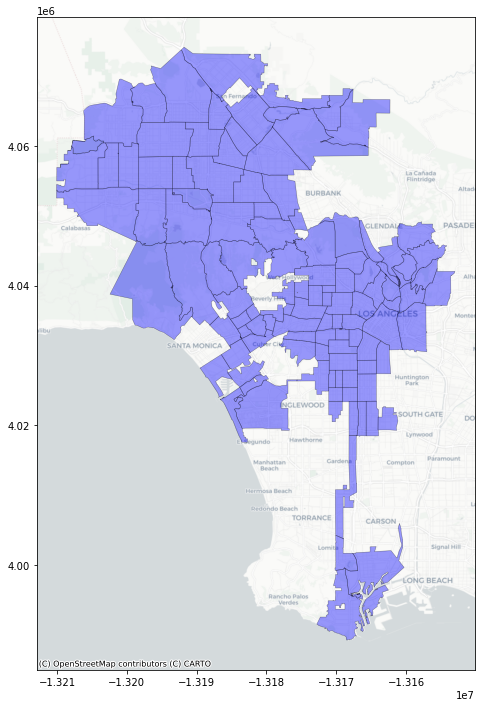

In [24]:
fig, ax = plt.subplots(figsize=(12,12))

Neighborhood_Boundaries.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=0.5,
         alpha=0.4)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Step 9 

I then overlayed smallplex data on top of the neighborhood dataset

In [25]:
fig, ax = plt.subplots(figsize=(20, 20))

Neighborhood_Boundaries.plot(ax=ax,
        color='blue', 
        edgecolor='black',
        alpha=0.5)

Smallplex_Data_With_Geometry.plot(ax=ax,
            color='red',
            markersize=10,
            alpha=0.5)


ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [26]:
Combined_Data = gpd.sjoin(Smallplex_Data_With_Geometry, Neighborhood_Boundaries,how='left')

Combined_Data.head(10)

PCIS Permit #        Permit Type Initiating Office Issue Date Zip Code  \
0  19010-20000-02371           Bldg-New          VAN NUYS      44134    90016   
1  17010-30000-00174           Bldg-New           WEST LA      43010    90035   
2  13010-20000-00689           Bldg-New          VAN NUYS      42004    91401   
3  16014-30000-06026      Bldg-Addition           WEST LA      43417    90007   
4  19010-20000-03276           Bldg-New          VAN NUYS      43851    91405   
5  19010-20000-03278           Bldg-New          VAN NUYS      43851    91405   
6  18014-10000-04349      Bldg-Addition             METRO      43858    90006   
7  17016-10000-05525  Bldg-Alter/Repair             METRO      42873    90006   
8  18010-20000-01339           Bldg-New          VAN NUYS      43343    91601   
9  15010-10001-03646           Bldg-New             METRO      42558    90272   

  Valuation # of Residential Dwelling Units Census Tract  Latitude  Longitude  \
0    800000                               4      2199.02  34.03317 -118.36779   
1   1780000                               4         2690  34.05319 -118.40537   
2    900000                               4      1286.01  34.17860 -118.44681   
3    950000                               4         2226  34.02108 -118.29312   
4    983714                               4       1235.1  34.19371 -118.42782   
5    983714                               4       1235.1  34.04936 -118.27833   
6    100000                               4       2095.2  34.05287 -118.28758   
7     20000                               4      2134.01  34.16404 -118.36134   
8    680000                               4         1256  34.04136 -118.55527   
9    723300                               4      2626.04  34.08662 -118.34757   

           Zone                           geometry  index_right  \
0       RD1.5-1  POINT (-13176642.109 4033256.817)          103   
1  [Q]RD2-1VL-O  POINT (-13180825.496 4035946.382)           72   
2    [Q]RD1.5-1  POINT (-13185438.575 4052808.928)           96   
3       RD1.5-1  POINT (-13168329.883 4031632.906)           31   
4    [Q]RD1.5-1  POINT (-13183324.618 4054842.299)           94   
5    [Q]RD1.5-1  POINT (-13166683.467 4035431.795)           73   
6     C1-1-HPOZ  POINT (-13167713.173 4035903.387)          106   
7          R4-1  POINT (-13175924.098 4050849.916)           91   
8       RD1.5-1  POINT (-13197512.287 4034357.017)           68   
9         RD2-1  POINT (-13174391.229 4040438.914)           32   

                name  
0         West Adams  
1     Pico-Robertson  
2           Van Nuys  
3    Exposition Park  
4        Valley Glen  
5         Pico-Union  
6           Westlake  
7        Toluca Lake  
8  Pacific Palisades  
9            Fairfax

## Step 10 

I then identified which neighborhoods had the most smallplexes

In [27]:
Smallplexes_By_Neighborhood = Combined_Data.name.value_counts().rename_axis('name').reset_index(name='smallplexes')

In [28]:
Smallplexes_By_Neighborhood

name  smallplexes
0                 Florence          258
1      Broadway-Manchester          147
2           East Hollywood          114
3            Boyle Heights          111
4          Exposition Park          110
5                 Mid-City          107
6          Central-Alameda           92
7            Green Meadows           88
8   Historic South-Central           84
9          North Hollywood           77
10          Vermont Square           77
11           Vermont Vista           69
12               Hollywood           68
13         Vermont-Slauson           60
14              South Park           59
15              Pico-Union           56
16          Vermont Knolls           53
17                Westlake           39
18             Playa Vista           35
19              West Adams           33
20                Van Nuys           30
21                  Venice           29
22                   Watts           24
23              Northridge           24
24               Hyde Park           23
25             Silver Lake           21
26               Echo Park           19
27               San Pedro           18
28         Harvard Heights           17
29             Valley Glen           17
30                Sawtelle           17
31       Manchester Square           15
32             Westchester           15
33               El Sereno           15
34               Larchmont           14
35                  Sylmar           13
36            Mid-Wilshire           13
37              Wilmington           13
38              Chatsworth           13
39          Harbor Gateway           12
40          Jefferson Park           12
41         University Park           12
42       Arlington Heights           11
43     Chesterfield Square           11
44              Eagle Rock           10
45         Adams-Normandie           10
46         Hollywood Hills           10
47             Studio City            9
48               Koreatown            8
49           Glassell Park            8
50             Harbor City            8
51                 Tujunga            7
52               Los Feliz            7
53            Sherman Oaks            7
54           Highland Park            7
55       Pacific Palisades            7
56                 Fairfax            6
57            Harvard Park            6
58             Toluca Lake            6
59              Sun Valley            6
60           Panorama City            5
61             Lake Balboa            5
62         Lincoln Heights            5
63                 Del Rey            5
64          Valley Village            5
65               Brentwood            4
66                Westwood            4
67           Beverly Grove            4
68               Mar Vista            4
69          Pico-Robertson            4
70             North Hills            3
71                   Palms            3
72           Gramercy Park            3
73                  Reseda            3
74               Chinatown            3
75                 Sunland            2
76                 Bel-Air            2
77                 Pacoima            2
78           Beverly Crest            2
79            Elysian Park            2
80                Downtown            2
81            Shadow Hills            2
82        West Los Angeles            1
83            Leimert Park            1
84            Cypress Park            1
85            Hancock Park            1
86            Century City            1
87             Rancho Park            1
88  Baldwin Hills/Crenshaw            1
89       Montecito Heights            1
90                  Encino            1
91             Canoga Park            1
92         Atwater Village            1

In [29]:
Neighborhood_Boundaries=Neighborhood_Boundaries.merge(Smallplexes_By_Neighborhood,on='name')

In [30]:
Neighborhood_Boundaries.sample(10)

name                                           geometry  \
17              Del Rey  POLYGON ((-13181312.332 4028876.314, -13181302...   
67         Sherman Oaks  POLYGON ((-13181762.605 4049854.240, -13181762...   
6         Beverly Grove  POLYGON ((-13177167.561 4040928.302, -13177166...   
89     West Los Angeles  POLYGON ((-13184035.863 4033825.958, -13184141...   
16         Cypress Park  POLYGON ((-13160082.354 4040761.894, -13159992...   
14  Chesterfield Square  POLYGON ((-13170095.318 4025388.643, -13170095...   
45      Lincoln Heights  POLYGON ((-13159319.592 4040071.686, -13159292...   
92          Lake Balboa  POLYGON ((-13191488.697 4058534.312, -13191488...   
9   Broadway-Manchester  POLYGON ((-13165705.323 4019297.776, -13165706...   
31         Hancock Park  POLYGON ((-13171985.141 4039042.010, -13171969...   

    smallplexes  
17            5  
67            7  
6             4  
89            1  
16            1  
14           11  
45            5  
92            5  
9           147  
31            1

## Step 11 

I then mapped the 20 neighborhoods with the most smallplexes and the 20 neighborhoods with the least duplexes

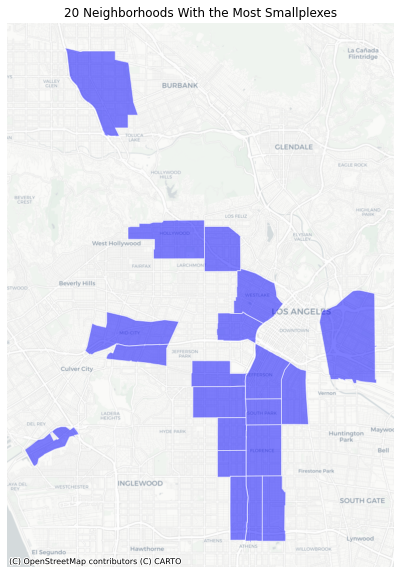

In [31]:
fig,ax = plt.subplots(figsize=(12,10))
Neighborhood_Boundaries.sort_values(by='smallplexes',ascending=False)[:20].plot(ax=ax,
                                                                 color='blue',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('20 Neighborhoods With the Most Smallplexes')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

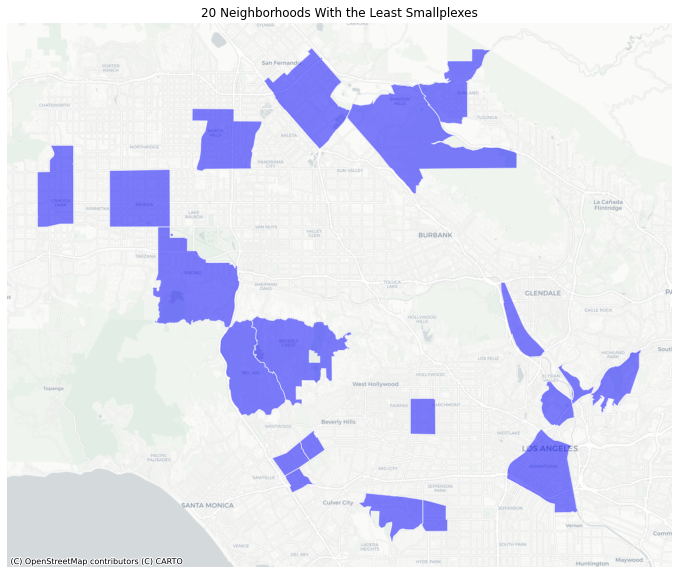

In [32]:
fig,ax = plt.subplots(figsize=(12,10))
Neighborhood_Boundaries.sort_values(by='smallplexes',ascending=True)[:20].plot(ax=ax,
                                                                 color='blue',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('20 Neighborhoods With the Least Smallplexes')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Step 12

I then did a chloropleth map to show the relationship that neighborhoods with large numbers of smallplexes have with neighborhoods with small numbers of smallplexes.

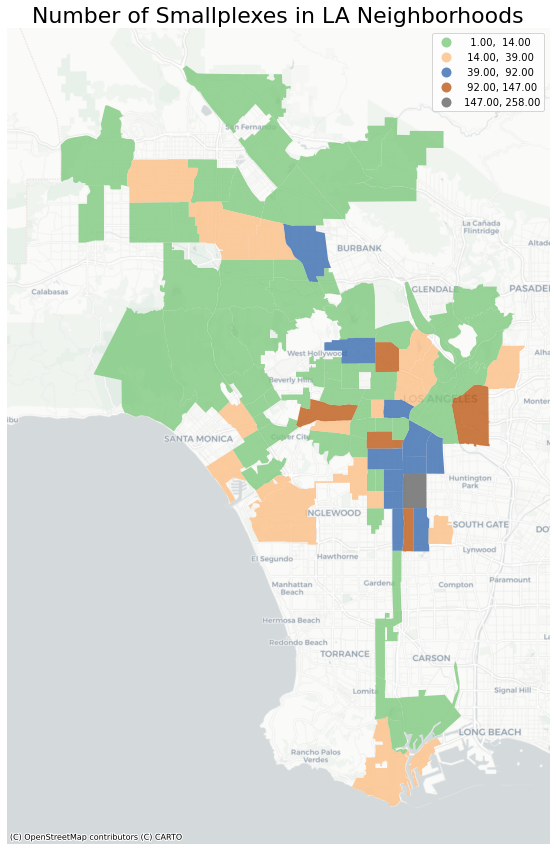

In [33]:
fig,ax = plt.subplots(figsize=(15,15))

Neighborhood_Boundaries.plot(ax=ax,
        column='smallplexes',
        legend=True,
        alpha=0.8,
        cmap='Accent',
        scheme='natural_breaks')

ax.axis('off')
ax.set_title('Number of Smallplexes in LA Neighborhoods',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Step 13

The following are just interactive maps that I created last time that include a loop function

In [34]:
def smallplex_map(Dwelling = '2'):
    
    Table = px.scatter_mapbox(Smallplex_Data_With_Geometry[Smallplex_Data_With_Geometry['# of Residential Dwelling Units'] == Dwelling],
                                                      lat='Latitude',
                        lon='Longitude',
                          color= '# of Residential Dwelling Units')
    Table.update_layout(mapbox_style="carto-darkmatter")

    Table.show()

In [35]:
smallplex_list = Smallplex_Data_With_Geometry['# of Residential Dwelling Units'].unique().tolist()
smallplex_list

['4', '3', '2']

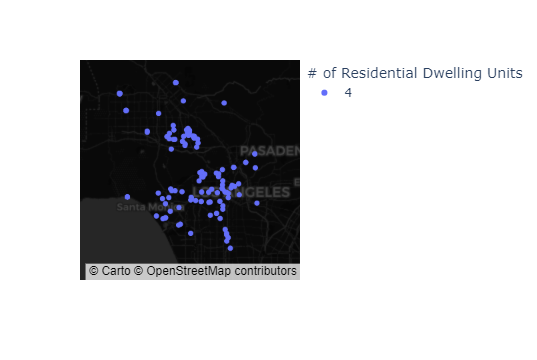

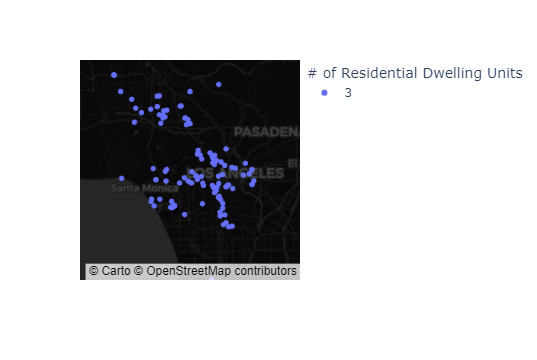

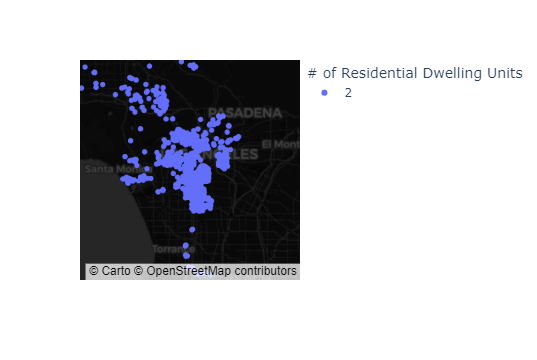

In [36]:
for Dwelling in smallplex_list:
    smallplex_map(Dwelling)